In [1]:
from __future__ import division
import sys
import time
import numpy as np
import pyrebase
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
NUM_TRAINING_IMAGES = 60000
NUM_TESTING_IMAGES = 10000
IMAGE_SIZE = 28
mnist_train_file = '/home/yang/Research/Privacy-preserving-DL/PPDL/DATA/MNIST/mnist_train.tfrecord'
mnist_test_file = '/home/yang/Research/Privacy-preserving-DL/PPDL/DATA/MNIST/mnist_test.tfrecord'

# parameters
batch_size = 500
epochs = 3   ## ?? ##
epsilon = .1 # privacy budget for each epoch
learning_rate = .1
grad_bound = .001
grad_threshold = .0001  # for SVT
grad_upload_ratio = .001 # ratio of parameters for uploading at each iteration
grad_upload_num = int((784*64 + 640) * grad_upload_ratio) # number of parameters for uploading at each iteration

In [3]:
def MnistInputAll(mnist_data_file):
  """Create operations to read the MNIST input file.
  Args:
    mnist_data_file: Path of a tfrecord file containing the MNIST images to process.

  Returns:
    images: A list with the formatted image data. shape [10000, 28*28]
    labels: A list with the labels for each image.  shape [10000]
  """
  with tf.Session() as sess:
      file_queue = tf.train.string_input_producer([mnist_data_file], num_epochs= 1)
      reader = tf.TFRecordReader()
      _, value = reader.read(file_queue)
      example = tf.parse_single_example(
          value,
          features={"image/encoded": tf.FixedLenFeature(shape=(), dtype=tf.string),
                    "image/class/label": tf.FixedLenFeature([1], tf.int64)})

      image = tf.cast(tf.image.decode_png(example["image/encoded"], channels=1),
                      tf.float32)
      image = tf.reshape(image, [IMAGE_SIZE * IMAGE_SIZE])
      image /= 255
      label = tf.cast(example["image/class/label"], dtype=tf.int32)
      label = tf.reshape(label, [])

      init_op = tf.global_variables_initializer()
      init_op2 = tf.local_variables_initializer()
      sess.run(init_op)
      sess.run(init_op2)
      coord = tf.train.Coordinator()
      threads = tf.train.start_queue_runners(coord=coord)
      images = []
      labels = []
      try:
          while True:
              i, l = sess.run([image, label])
              i = i.tolist()
              images.append(i)
              labels.append(l)
      except tf.errors.OutOfRangeError, e:
          coord.request_stop(e)
      finally:
          coord.request_stop()
          coord.join(threads)

      return images, labels

In [7]:
mnist_train_file = '/home/yang/Research/Privacy-preserving-DL/PPDL/DATA/MNIST/mnist_train.tfrecord'
mnist_test_file = '/home/yang/Research/Privacy-preserving-DL/PPDL/DATA/MNIST/mnist_test.tfrecord'

In [10]:
images, labels = MnistInputAll(mnist_train_file) 

In [23]:
image_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

In [25]:
type(image_tensor)

tensorflow.python.framework.ops.Tensor

In [26]:
image_tensor

<tf.Tensor 'Const:0' shape=(60000, 784) dtype=float32>

In [30]:
def MnistInput(mnist_data_file, whole = True, start = None, size = None):
    """Create operations to read the MNIST input file.
      Args:
        mnist_data_file: Path of a tfrecord file containing the MNIST images to process.
        whole: when set to true, return the whole MNIST dataset (training or test set)
        start: start index of the first sample in the user dataset
        size: size of the user dataset
    
      Returns:
        images: A list with the formatted image data. default shape [10000, 28*28]
        labels: A list with the labels for each image. default shape [10000]
      """
    with tf.Session() as sess:
        file_queue = tf.train.string_input_producer([mnist_data_file], num_epochs= 1)
        reader = tf.TFRecordReader()
        _, value = reader.read(file_queue)
        example = tf.parse_single_example(
            value,
            features={"image/encoded": tf.FixedLenFeature(shape=(), dtype=tf.string),
                    "image/class/label": tf.FixedLenFeature([1], tf.int64)})

        image = tf.cast(tf.image.decode_png(example["image/encoded"], channels=1),
                      tf.float32)
        image = tf.reshape(image, [IMAGE_SIZE * IMAGE_SIZE])
        image /= 255
        label = tf.cast(example["image/class/label"], dtype=tf.int32)
        label = tf.reshape(label, [])

        init_op = tf.global_variables_initializer()
        init_op2 = tf.local_variables_initializer()
        sess.run(init_op)
        sess.run(init_op2)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        images = []
        labels = []
        if whole:
            try:
                while True:
                    i, l = sess.run([image, label])
                    i = i.tolist()
                    images.append(i)
                    labels.append(l)
            except tf.errors.OutOfRangeError, e:
                coord.request_stop(e)
            finally:
                coord.request_stop()
                coord.join(threads)
        else:
            try:
                for k in xrange(start - 1):
                    sess.run([image, label])
                for k in xrange(start, start + size):
                    i, l = sess.run([image, label])
                    i = i.tolist()
                    images.append(i)
                    labels.append(l)
            except tf.errors.OutOfRangeError, e:
                coord.request_stop(e)
            finally:
                coord.request_stop()
                coord.join(threads)
        
        
        return images, labels

In [6]:
images, labels = MnistInput(mnist_train_file, whole = True) 

In [31]:
image1, label1 = MnistInput(mnist_train_file, whole = False, start = 10, size = 50) 

In [9]:
len(images)

60000

In [10]:
len(image1)

50

In [13]:
a = [1,2,3,4,5,65,6,7,8,9]

In [49]:
import random
random.seed(10)

print(random.sample(range(100),6))

[57, 42, 20, 81, 82, 65]


In [53]:
random.sample(labels,60)

[7,
 9,
 4,
 1,
 7,
 2,
 1,
 7,
 0,
 0,
 3,
 1,
 3,
 7,
 5,
 7,
 7,
 0,
 0,
 4,
 1,
 9,
 6,
 2,
 7,
 8,
 3,
 4,
 5,
 3,
 8,
 7,
 4,
 5,
 0,
 8,
 6,
 8,
 9,
 3,
 8,
 4,
 4,
 1,
 2,
 9,
 3,
 2,
 8,
 2,
 3,
 2,
 8,
 9,
 9,
 7,
 0,
 8,
 9,
 5]

In [50]:
type(images)

list

In [56]:
[labels[i] for i in [57, 42, 20, 81, 82, 65]]

[9, 7, 4, 0, 2, 5]

In [7]:
a = np.random.laplace(loc=0,scale=1, size=10000)

In [8]:
a

array([ 0.62409199,  0.02899798,  0.66684927, ..., -0.20577036,
        1.03475273,  0.94325796])

In [11]:
import matplotlib.pyplot as plt
plt.hist(a, 50, normed=1, facecolor='g', alpha=0.75)

/home/yang/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


(array([  2.79446400e-04,   2.79446400e-04,   8.38339199e-04,
          0.00000000e+00,   5.58892800e-04,   5.58892800e-04,
          1.11778560e-03,   1.67667840e-03,   2.79446400e-03,
          2.23557120e-03,   3.91224960e-03,   1.08984096e-02,
          8.38339199e-03,   1.50901056e-02,   2.12379264e-02,
          2.99007648e-02,   4.58292096e-02,   6.79054752e-02,
          9.30556511e-02,   1.42797110e-01,   1.86949641e-01,
          2.62679616e-01,   3.84518246e-01,   4.48232025e-01,
          3.27231734e-01,   2.26351584e-01,   1.49224378e-01,
          1.10101882e-01,   7.06999392e-02,   5.78454048e-02,
          3.63280320e-02,   2.79446400e-02,   1.98406944e-02,
          9.78062399e-03,   9.50117759e-03,   4.75058880e-03,
          3.07391040e-03,   3.63280320e-03,   1.67667840e-03,
          1.67667840e-03,   5.58892800e-04,   5.58892800e-04,
          5.58892800e-04,   2.79446400e-04,   0.00000000e+00,
          0.00000000e+00,   2.79446400e-04,   2.79446400e-04,
        

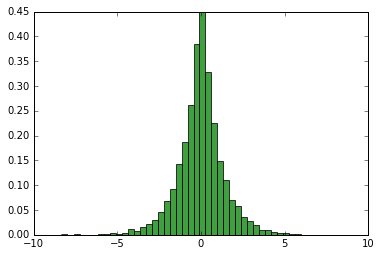

In [12]:
plt.show()

In [20]:
b = sorted(range(len(a)), key=lambda i: abs(a[i]))[-5:]

In [17]:
a = [1, 2, 3, 4, 5, -65, 6, 7, 8, 9]

In [21]:
b

[6, 7, 8, 9, 5]

In [22]:
[a[i] for i in b]

[6, 7, 8, 9, -65]

In [23]:
c = [0]*10

In [24]:
c

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [25]:
ls = [a[i] if i in b else 0 for i in range(10)]

In [26]:
ls

[0, 0, 0, 0, 0, -65, 6, 7, 8, 9]

In [27]:
a

[1, 2, 3, 4, 5, -65, 6, 7, 8, 9]

In [33]:
import csv

with open('test1.csv', 'wb') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(image1)

In [32]:
type(image1)

list

In [34]:
image1

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.7411764860153198,
  0.7450980544090271,
  0.0,
  0.0,
  0.

In [49]:
%ls

allFunc.py                      __init__.py                test1.csv
all_func.pyc                    __init__.pyc               test.csv
allUser.pyc                     loss_logreg.py             TEST.ipynb
config.py                       loss_logreg.pyc            u1.py*
config.pyc                      noise.py                   u2.py*
dataPrep.py                     noise.pyc                  User1.py
dataPrep.pyc                    per_example_gradients.py   User1.pyc
dataset_utils.py                per_example_gradients.pyc  User2.py
dataset_utils.pyc               prep.py                    User3.py
download_and_convert_mnist.py   prep.pyc                   userData/
download_and_convert_mnist.pyc  q.py                       utils.py
dp_optimizer.py                 sanitizer.py               utils.pyc
dp_optimizer.pyc                sanitizer.pyc


In [51]:
import allFunc